In [1]:
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


 ## 1. Custom Dataset Creation

 We'll create a custom dataset that combines MNIST and FashionMNIST

In [2]:
class CombinedDataset(Dataset):
    """
    Dataset class that combines MNIST and FashionMNIST datasets.
    MNIST classes: 0-9
    FashionMNIST classes: 10-19
    """
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.transform = transform

        # Load MNIST
        mnist = datasets.MNIST(root=root, train=train, download=download, transform=None)

        # Load FashionMNIST
        fashion_mnist = datasets.FashionMNIST(root=root, train=train, download=download, transform=None)

        # Combine the data (normalize to [0, 1] range)
        self.data = torch.cat([
            mnist.data.unsqueeze(1).float() / 255.0,
            fashion_mnist.data.unsqueeze(1).float() / 255.0
        ])

        # Combine the targets (shift FashionMNIST labels by 10)
        self.targets = torch.cat([
            mnist.targets,
            fashion_mnist.targets + 10
        ])

        # Create class names
        self.class_names = [str(i) for i in range(10)]  # MNIST digits
        self.class_names.extend([  # FashionMNIST items
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.targets[idx])

        if self.transform:
            img = self.transform(img)

        return img, target


 ## 2. Data Loaders & Visualization

In [3]:
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
    transforms.ColorJitter(brightness=0.2),  # Random brightness adjustment
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Create datasets
train_dataset = CombinedDataset(train=True, transform=train_transform)
val_dataset = CombinedDataset(train=False, transform=test_transform)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Dataset info
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.class_names)}")


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.15MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 172kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


Training samples: 120000
Validation samples: 20000
Number of classes: 20


 ### Visualize Sample Images from Combined Dataset

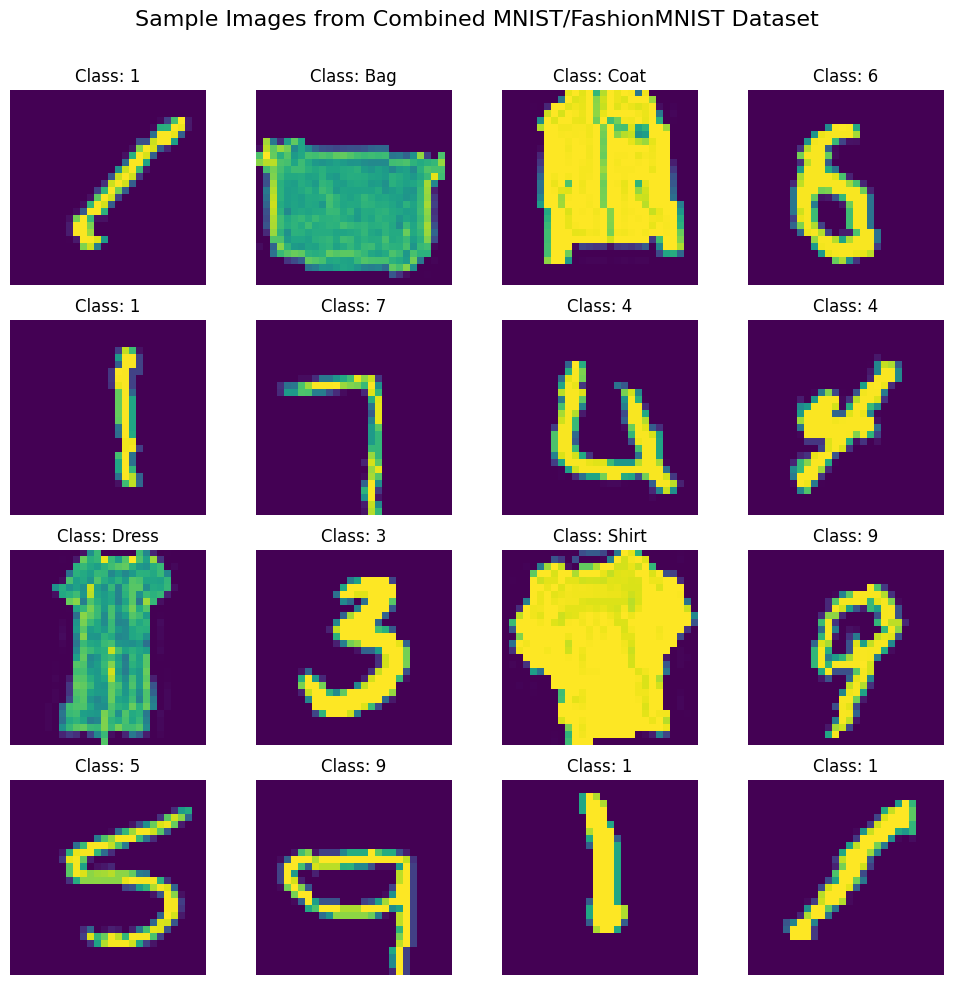

In [4]:
def display_samples(dataloader, num_samples=16, figsize=(10, 10)):
    """Display random samples from the dataset with their labels"""
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Convert images from [-1, 1] to [0, 1] for display
    images = (images * 0.5 + 0.5).squeeze()

    # Create a grid to display the images
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)

    # Get class names
    class_names = dataloader.dataset.class_names

    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(images[i], cmap='viridis')  # Use viridis colormap
            ax.set_title(f"Class: {class_names[labels[i]]}")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.suptitle('Sample Images from Combined MNIST/FashionMNIST Dataset', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Display samples
display_samples(train_loader)


 ## 3. Implementing Rotary Positional Embeddings (RoPE)

In [5]:
class RotaryEmbedding(nn.Module):
    """
    Implements Rotary Position Embedding (RoPE) as described in
    "RoFormer: Enhanced Transformer with Rotary Position Embedding" (Su et al., 2021)
    """
    def __init__(self, dim, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        self.inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.max_seq_len_cached = 0  # Initialize to 0 instead of None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x, seq_len):
        """
        Apply rotary embeddings to input tensor x
        Args:
            x: Input tensor of shape [batch_size, seq_len, channels]
            seq_len: Sequence length
        Returns:
            Tuple of (cos, sin) tensors for applying rotary embeddings
        """
        # Check if we need to compute new cache values
        if seq_len > self.max_seq_len_cached or self.cos_cached is None or self.sin_cached is None:
            self.max_seq_len_cached = max(seq_len, 128)  # Use at least 128 to prevent frequent recalculations
            t = torch.arange(self.max_seq_len_cached, device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum('i,j->ij', t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[:, None, None, :]
            self.sin_cached = emb.sin()[:, None, None, :]

        # Return cached values up to the needed sequence length
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]

def rotate_half(x):
    """Rotate half the hidden dims of the input"""
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin):
    """Apply rotary position embeddings to q and k tensors"""
    # Make sure cos and sin have the right shape for broadcasting
    # They should be [seq_len, 1, 1, dim//2]

    # Apply only to the first half of the dimensions
    dim = q.shape[-1]
    q_half, q_other = q[..., :dim//2], q[..., dim//2:]
    k_half, k_other = k[..., :k.shape[-1]//2], k[..., k.shape[-1]//2:]

    # Make sure cos and sin are properly sized
    # Get the sequence length from the query
    seq_len = q.shape[2]
    if cos.shape[0] > seq_len:
        cos = cos[:seq_len]
        sin = sin[:seq_len]

    # Reshape for proper broadcasting
    # The cos/sin have shape [seq_len, 1, 1, dim//2]
    # We need to move seq_len to the right position for q and k
    # q and k have shape [batch, heads, seq_len, dim//2]
    cos = cos.permute(1, 2, 0, 3)  # [1, 1, seq_len, dim//2]
    sin = sin.permute(1, 2, 0, 3)  # [1, 1, seq_len, dim//2]

    # Apply rotary embeddings
    q_half_rotated = (q_half * cos) + (rotate_half(q_half) * sin)
    k_half_rotated = (k_half * cos) + (rotate_half(k_half) * sin)

    # Concatenate back with the unchanged half
    q_rotated = torch.cat([q_half_rotated, q_other], dim=-1)
    k_rotated = torch.cat([k_half_rotated, k_other], dim=-1)

    return q_rotated, k_rotated


 ## 4. Vision-nanoGPT Model Architecture

In [6]:
class VisionGPTConfig:
    """Configuration class for VisionGPT model"""
    def __init__(self, **kwargs):
        # Image parameters
        self.img_size = 28  # MNIST/FashionMNIST image size
        self.patch_size = 4  # Size of each patch
        self.in_channels = 1  # Grayscale images

        # Model parameters
        self.n_layer = 8  # Number of transformer layers
        self.n_head = 8  # Number of attention heads
        self.n_embd = 256  # Embedding dimension
        self.dropout = 0.1  # Dropout probability
        self.bias = True  # Use bias in layers

        # Output parameters
        self.n_classes = 20  # 10 MNIST + 10 FashionMNIST

        # Calculate sequence length
        self.seq_len = (self.img_size // self.patch_size) ** 2 + 1  # +1 for classification token

        # Override defaults with kwargs
        for k, v in kwargs.items():
            setattr(self, k, v)

class PatchEmbedding(nn.Module):
    """Convert image into patch embeddings with a cls token"""
    def __init__(self, config):
        super().__init__()
        self.img_size = config.img_size
        self.patch_size = config.patch_size
        self.in_channels = config.in_channels
        self.embed_dim = config.n_embd

        # Compute number of patches
        self.num_patches = (self.img_size // self.patch_size) ** 2

        # Conv layer to extract patches
        self.proj = nn.Conv2d(
            self.in_channels,
            self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )

        # Classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))

        # Initialize parameters
        nn.init.normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # Input shape: [B, C, H, W]
        B = x.shape[0]

        # Project images to embedding space
        x = self.proj(x)  # [B, embed_dim, H/patch_size, W/patch_size]

        # Flatten spatial dimensions
        x = x.flatten(2)  # [B, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [B, num_patches, embed_dim]

        # Add classification token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1 + num_patches, embed_dim]

        return x

class SelfAttention(nn.Module):
    """Multi-head self-attention with rotary positional embeddings"""
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Dimensions
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head

        # Query, key, value projections
        self.query = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.key = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.value = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Dropout
        self.dropout = nn.Dropout(config.dropout)

        # Rotary embeddings (applied to half of the dimensions)
        self.rope = RotaryEmbedding(self.head_dim // 2)

        # Flash attention if available
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

    def forward(self, x):
        # x shape: [batch_size, seq_len, n_embd]
        B, T, C = x.shape

        # Calculate q, k, v
        q = self.query(x)  # [B, T, C]
        k = self.key(x)    # [B, T, C]
        v = self.value(x)  # [B, T, C]

        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B, nh, T, hd]
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B, nh, T, hd]
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B, nh, T, hd]

        # Apply rotary embeddings (only to half the dimensions)
        cos, sin = self.rope(x, seq_len=T)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # Compute attention
        if self.flash:
            # Use flash attention for efficiency (PyTorch 2.0+)
            y = F.scaled_dot_product_attention(q, k, v, dropout_p=0.0)
        else:
            # Compute attention scores
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

            # Apply softmax and dropout
            attn = F.softmax(scores, dim=-1)
            attn = self.dropout(attn)

            # Apply attention weights
            y = torch.matmul(attn, v)  # [B, nh, T, hd]

        # Reshape back
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # [B, T, C]

        # Output projection
        y = self.proj(y)
        y = self.dropout(y)

        return y

class FeedForward(nn.Module):
    """Position-wise feed-forward network"""
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer block with self-attention and feed-forward layers"""
    def __init__(self, config):
        super().__init__()
        # Layer normalization
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)

        # Self-attention
        self.attn = SelfAttention(config)

        # Feed-forward
        self.ff = FeedForward(config)

    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attn(self.ln1(x))

        # Feed-forward with residual connection
        x = x + self.ff(self.ln2(x))

        return x

class VisionGPT(nn.Module):
    """VisionGPT model integrating nanoGPT architecture with vision capabilities"""
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Patch embedding
        self.patch_embed = PatchEmbedding(config)

        # Dropout
        self.drop = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(config) for _ in range(config.n_layer)
        ])

        # Final layer norm
        self.ln_f = nn.LayerNorm(config.n_embd)

        # Classification head
        self.head = nn.Linear(config.n_embd, config.n_classes, bias=False)

        # Apply weight initialization
        self.apply(self._init_weights)

        # Print model size
        print(f"VisionGPT model with {sum(p.numel() for p in self.parameters() if p.requires_grad):,} parameters")

    def _init_weights(self, module):
        """Initialize weights"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def get_attention_maps(self, x):
        """Get attention maps for visualization"""
        B = x.shape[0]

        # Get patch embeddings
        x = self.patch_embed(x)

        # Apply dropout
        x = self.drop(x)

        # Store attention maps
        attention_maps = []

        # Forward through blocks
        for block in self.blocks:
            # Apply layer norm
            ln_out = block.ln1(x)

            # Get q, k from the self-attention module
            q = block.attn.query(ln_out)
            k = block.attn.key(ln_out)

            # Reshape for multi-head attention
            T = ln_out.shape[1]  # sequence length
            q = q.view(B, T, block.attn.n_head, block.attn.head_dim).transpose(1, 2)
            k = k.view(B, T, block.attn.n_head, block.attn.head_dim).transpose(1, 2)

            # Apply rotary embeddings
            cos, sin = block.attn.rope(ln_out, seq_len=T)
            q, k = apply_rotary_pos_emb(q, k, cos, sin)

            # Compute attention scores
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(block.attn.head_dim)
            attention = F.softmax(scores, dim=-1)

            # Average across heads
            attention = attention.mean(dim=1)  # [B, seq_len, seq_len]
            attention_maps.append(attention)

            # Continue with the rest of the forward pass
            x = block(x)

        return attention_maps

    def forward(self, x, targets=None):
        # Get patch embeddings
        x = self.patch_embed(x)

        # Apply dropout
        x = self.drop(x)

        # Forward through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply final layer norm
        x = self.ln_f(x)

        # Get CLS token for classification
        cls = x[:, 0]

        # Apply classification head
        logits = self.head(cls)

        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)

        return logits, loss


 ## 5. Model Initialization and Training Setup

In [7]:
# Initialize model configuration
config = VisionGPTConfig(
    img_size=28,
    patch_size=4,
    in_channels=1,
    n_layer=8,
    n_head=8,
    n_embd=256,
    dropout=0.1,
    bias=True,
    n_classes=20
)

# Create model and move to device
model = VisionGPT(config).to(device)

# Define optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.1,
    betas=(0.9, 0.95)
)

# Learning rate scheduler with cosine decay
def get_lr_scheduler(optimizer, warmup_iters=100, max_iters=2000, min_lr=1e-5):
    def lr_lambda(iter_num):
        # Linear warmup
        if iter_num < warmup_iters:
            return float(iter_num) / float(max(1, warmup_iters))
        # Cosine decay
        decay_ratio = (iter_num - warmup_iters) / (max_iters - warmup_iters)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return max(min_lr, min_lr + coeff * (1.0 - min_lr))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(
    optimizer,
    warmup_iters=100,
    max_iters=len(train_loader) * 5,  # 5 epochs
    min_lr=1e-5
)


VisionGPT model with 6,328,320 parameters


 ## 6. Training and Evaluation Functions

In [8]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch_idx, (images, targets) in enumerate(progress_bar):
        # Move data to device
        images, targets = images.to(device), targets.to(device)

        # Forward pass
        logits, loss = model(images, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        scheduler.step()

        # Calculate accuracy
        _, predicted = logits.max(1)
        batch_correct = predicted.eq(targets).sum().item()

        # Update metrics
        total_loss += loss.item() * images.size(0)
        correct += batch_correct
        total += targets.size(0)

        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100. * batch_correct / targets.size(0),
            'lr': current_lr
        })

    # Calculate epoch metrics
    epoch_loss = total_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

# Evaluation function
@torch.no_grad()
def evaluate(model, dataloader, device):
    """Evaluate the model on a dataloader"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Evaluating")
    for images, targets in progress_bar:
        # Move data to device
        images, targets = images.to(device), targets.to(device)

        # Forward pass
        logits, loss = model(images, targets)

        # Calculate accuracy
        _, predicted = logits.max(1)
        batch_correct = predicted.eq(targets).sum().item()

        # Update metrics
        total_loss += loss.item() * images.size(0)
        correct += batch_correct
        total += targets.size(0)

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100. * batch_correct / targets.size(0)
        })

    # Calculate final metrics
    avg_loss = total_loss / total
    accuracy = 100. * correct / total

    return avg_loss, accuracy

# Get all predictions for a dataset
@torch.no_grad()
def get_all_predictions(model, dataloader, device):
    """Get all predictions and targets from a dataloader"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    for images, targets in tqdm(dataloader, desc="Getting predictions"):
        images = images.to(device)

        # Forward pass
        logits, _ = model(images)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(dim=1)

        # Move to CPU
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
        all_targets.append(targets)

    # Concatenate
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return all_preds, all_probs, all_targets


 ## 7. Training Loop

In [9]:
# Set up training parameters
num_epochs = 5
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Set up metrics tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Initial evaluation
print("Initial evaluation...")
val_loss, val_acc = evaluate(model, val_loader, device)
print(f"Initial validation: Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

# Training loop
best_val_acc = val_acc
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)

    # Validate
    val_loss, val_acc = evaluate(model, val_loader, device)

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(scheduler.get_last_lr()[0])

    # Print results
    print(f"Epoch {epoch+1} results:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save checkpoint if improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'config': vars(config),
            'val_acc': val_acc,
            'val_loss': val_loss
        }
        torch.save(checkpoint, os.path.join(save_dir, 'best_model.pt'))
        print(f"  Saved new best model with val_acc: {val_acc:.2f}%")

    # Save latest model
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'config': vars(config),
        'val_acc': val_acc,
        'val_loss': val_loss
    }
    torch.save(checkpoint, os.path.join(save_dir, 'latest_model.pt'))

print("Training completed!")


Initial evaluation...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Initial validation: Loss: 3.0480, Accuracy: 6.82%

Epoch 1/5


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 results:
  Train Loss: 0.7960, Train Acc: 72.07%
  Val Loss: 0.3670, Val Acc: 86.36%
  Saved new best model with val_acc: 86.36%

Epoch 2/5


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 results:
  Train Loss: 0.3544, Train Acc: 87.02%
  Val Loss: 0.2638, Val Acc: 90.27%
  Saved new best model with val_acc: 90.27%

Epoch 3/5


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 results:
  Train Loss: 0.2653, Train Acc: 90.27%
  Val Loss: 0.2001, Val Acc: 92.48%
  Saved new best model with val_acc: 92.48%

Epoch 4/5


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 results:
  Train Loss: 0.2101, Train Acc: 92.29%
  Val Loss: 0.1703, Val Acc: 93.72%
  Saved new best model with val_acc: 93.72%

Epoch 5/5


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 results:
  Train Loss: 0.1789, Train Acc: 93.48%
  Val Loss: 0.1596, Val Acc: 94.14%
  Saved new best model with val_acc: 94.14%
Training completed!


 ## 8. Model Performance Visualization

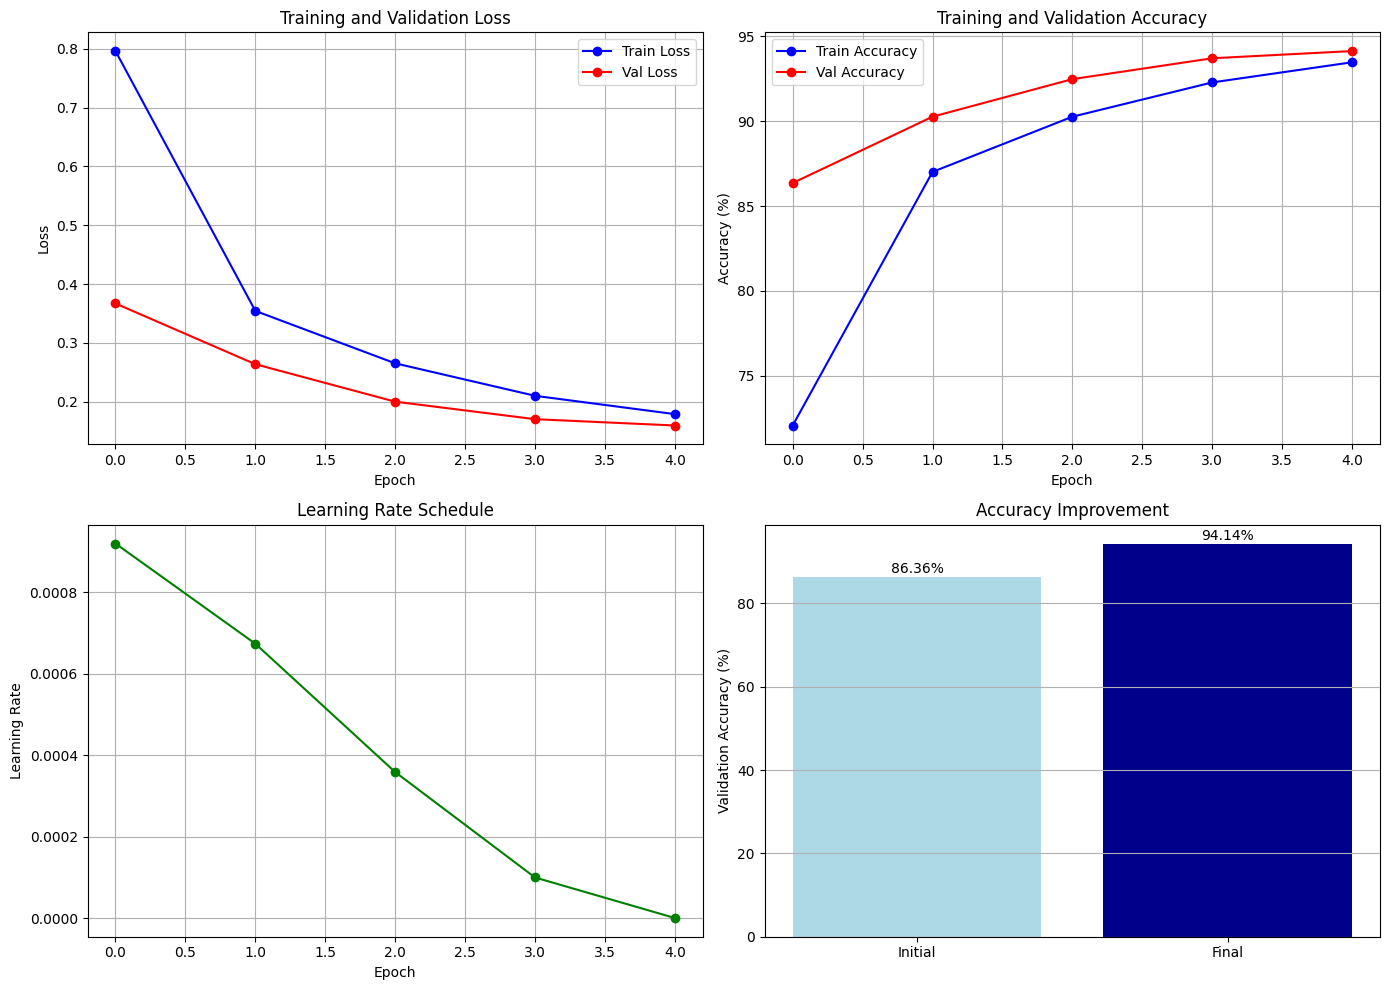

In [10]:
# Plot training history
def plot_training_history(history):
    """Plot training metrics over time"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Loss plot
    axes[0, 0].plot(history['train_loss'], 'bo-', label='Train Loss')
    axes[0, 0].plot(history['val_loss'], 'ro-', label='Val Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy plot
    axes[0, 1].plot(history['train_acc'], 'bo-', label='Train Accuracy')
    axes[0, 1].plot(history['val_acc'], 'ro-', label='Val Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning rate plot
    axes[1, 0].plot(history['lr'], 'go-')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True)

    # Training progress
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]

    # Accuracy improvement
    axes[1, 1].bar(['Initial', 'Final'], [history['val_acc'][0], history['val_acc'][-1]],
                  color=['lightblue', 'darkblue'])
    axes[1, 1].set_ylabel('Validation Accuracy (%)')
    axes[1, 1].set_title('Accuracy Improvement')
    axes[1, 1].grid(axis='y')

    # Add value labels
    for i, v in enumerate([history['val_acc'][0], history['val_acc'][-1]]):
        axes[1, 1].text(i, v+1, f"{v:.2f}%", ha='center')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


 ## 9. Model Evaluation and Analysis

Loaded best model from epoch 5
Best validation accuracy: 94.14%


Getting predictions:   0%|          | 0/157 [00:00<?, ?it/s]

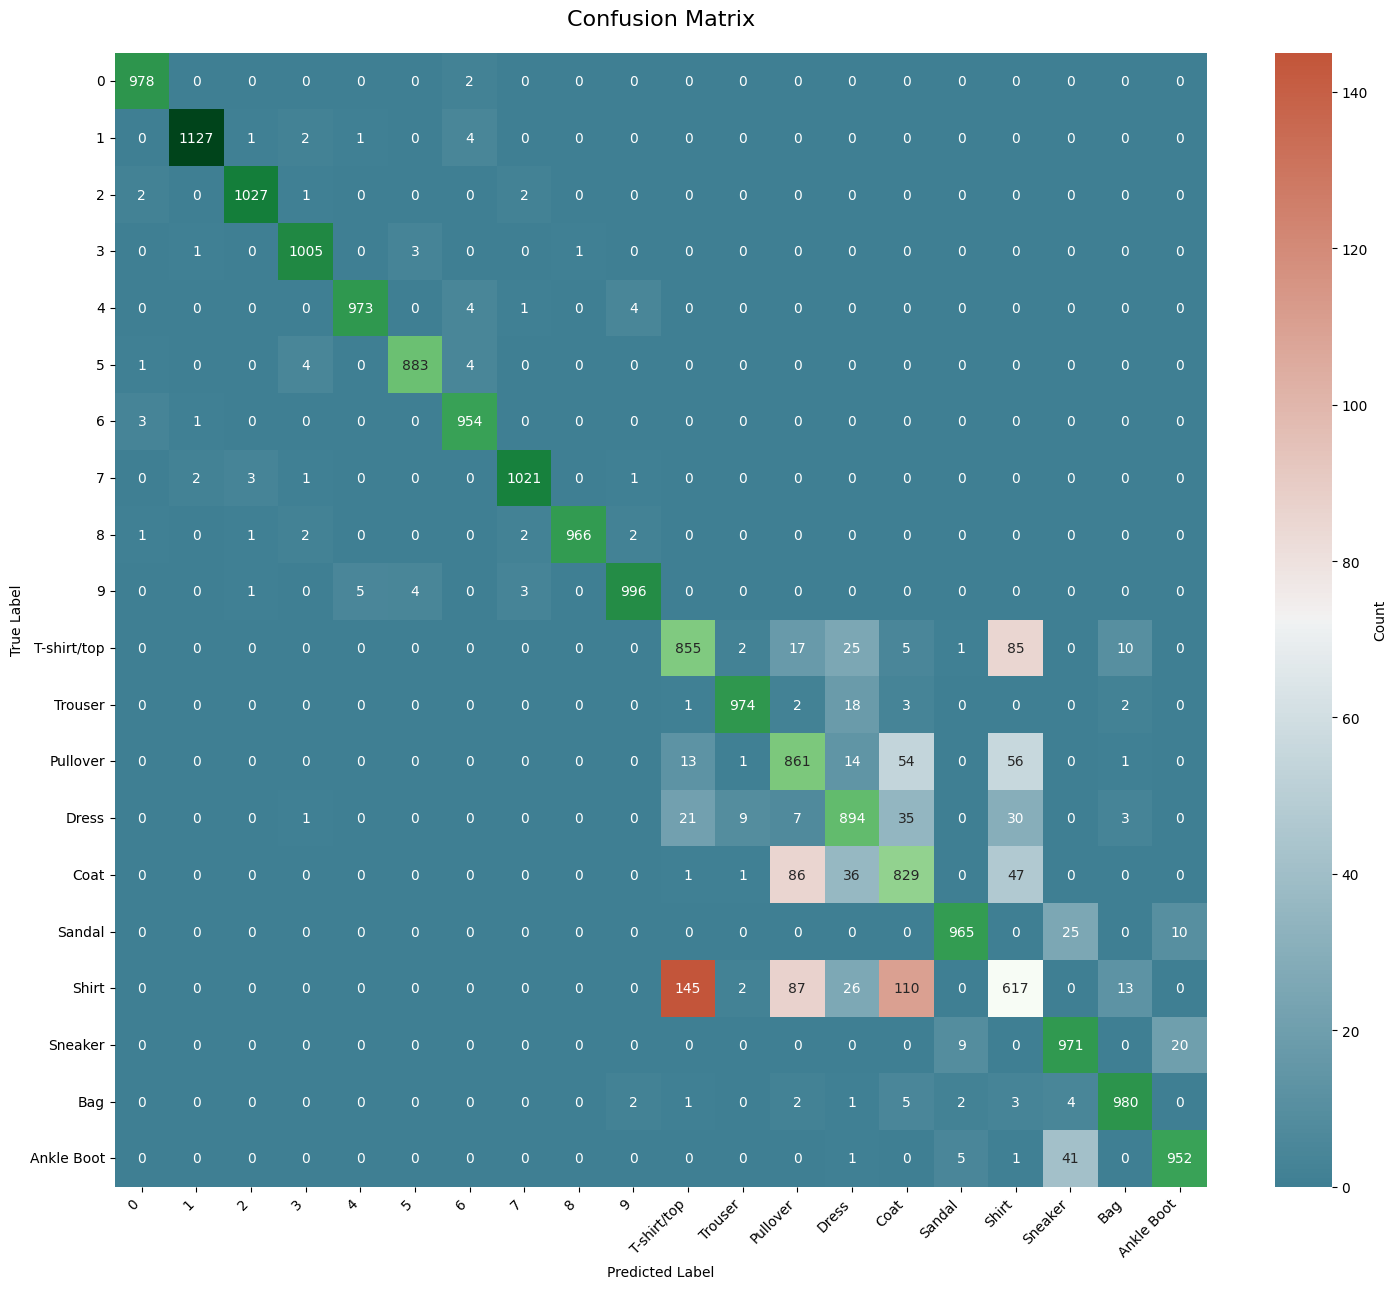

In [11]:
# Load the best model
best_checkpoint = torch.load(os.path.join(save_dir, 'best_model.pt'))
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {best_checkpoint['epoch']+1}")
print(f"Best validation accuracy: {best_checkpoint['val_acc']:.2f}%")

# Get predictions on validation set
val_preds, val_probs, val_targets = get_all_predictions(model, val_loader, device)

# Confusion Matrix Visualization
def plot_confusion_matrix(targets, predictions, class_names):
    """Create and plot confusion matrix with advanced styling"""
    cm = confusion_matrix(targets, predictions)

    plt.figure(figsize=(15, 13))

    # Use a custom colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Create a mask for the diagonal to highlight it
    mask = np.zeros_like(cm, dtype=bool)
    np.fill_diagonal(mask, True)

    # Plot off-diagonal elements
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, mask=mask,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    # Plot diagonal elements with a different color
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', mask=~mask,
                xticklabels=class_names, yticklabels=class_names,
                cbar=False)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix with custom styling
plot_confusion_matrix(val_targets, val_preds, val_dataset.class_names)


 ### Per-Class Performance Analysis

<Figure size 1400x800 with 0 Axes>

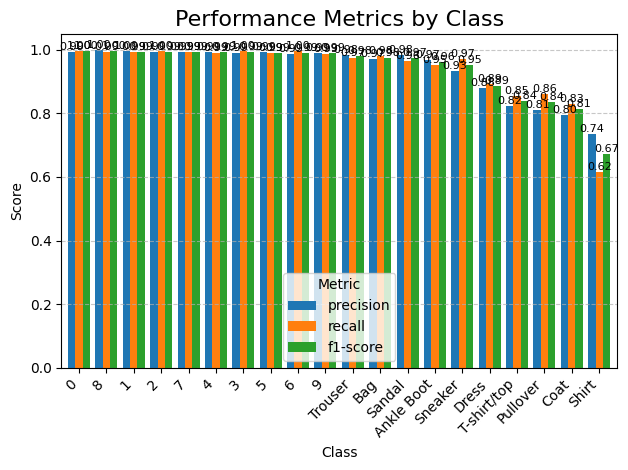

In [12]:
# Per-class performance
def analyze_per_class_performance(targets, predictions, class_names, probabilities=None):
    """Analyze model performance for each class"""
    # Calculate metrics for each class
    report = classification_report(targets, predictions, target_names=class_names, output_dict=True)

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(report).T
    df = df.iloc[:-3]  # Remove the avg rows

    # Sort by accuracy (f1-score)
    df = df.sort_values('f1-score', ascending=False)

    # Calculate confidence (mean probability) for each class
    if probabilities is not None:
        mean_confidence = []
        for i, class_name in enumerate(class_names):
            # Get samples of this class
            class_idx = np.where(targets == i)[0]
            if len(class_idx) > 0:
                # Get average probability assigned to correct class
                conf = np.mean(probabilities[class_idx, i])
                mean_confidence.append(conf)
            else:
                mean_confidence.append(0)

        # Add to dataframe
        confidence_df = pd.DataFrame({
            'class': class_names,
            'mean_confidence': mean_confidence
        })
        confidence_df = confidence_df.set_index('class')

        # Match order of df
        confidence_df = confidence_df.loc[df.index]
        df['mean_confidence'] = confidence_df['mean_confidence']

    return df

# Get per-class performance
import pandas as pd
class_df = analyze_per_class_performance(val_targets, val_preds, val_dataset.class_names, val_probs)

# Plot per-class performance metrics
plt.figure(figsize=(14, 8))

# Only show a subset of metrics
metrics_to_plot = ['precision', 'recall', 'f1-score']
class_df_plot = class_df[metrics_to_plot].copy()

# Create bar plot
ax = class_df_plot.plot(kind='bar', width=0.8)
plt.title('Performance Metrics by Class', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

plt.tight_layout()
plt.show()


 ### MNIST vs FashionMNIST Performance Comparison

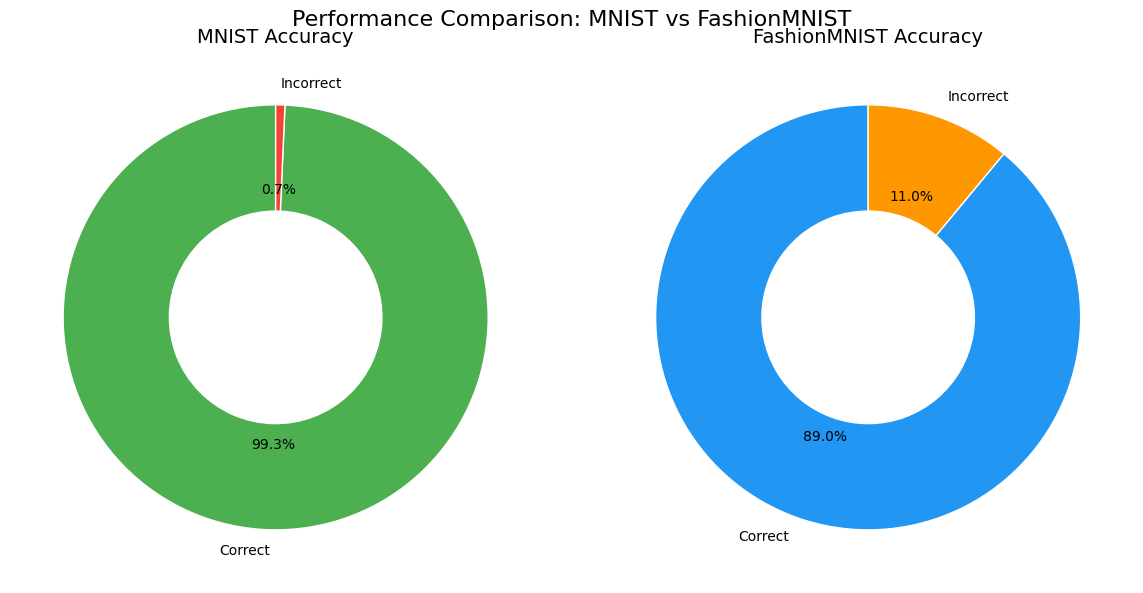

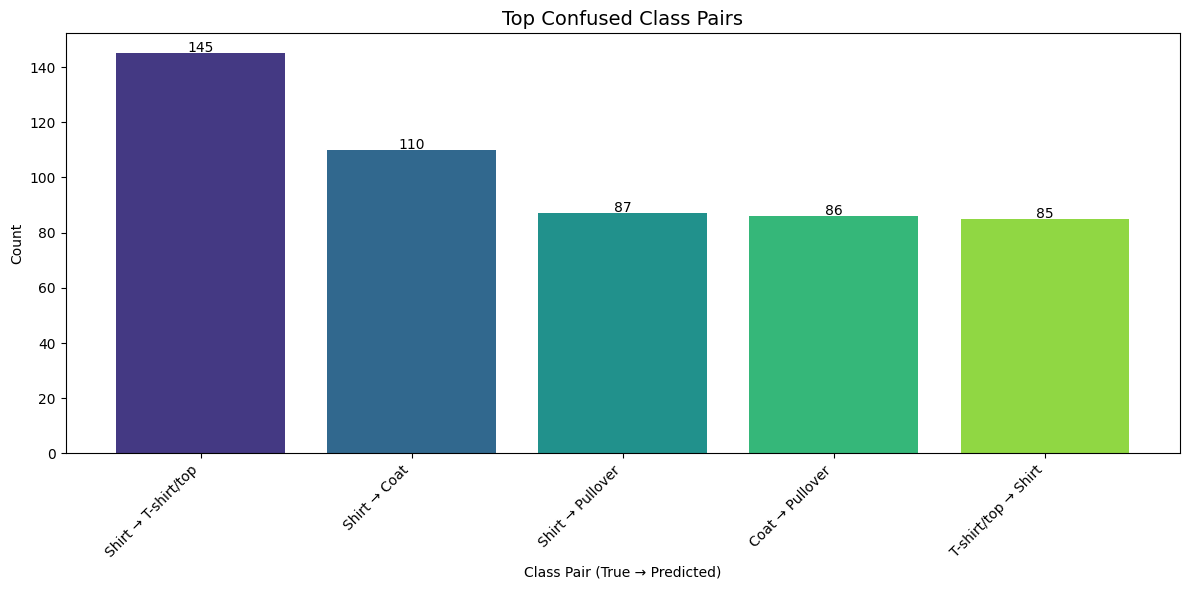

In [13]:
# Separate performance for MNIST vs FashionMNIST
mnist_indices = np.where(val_targets < 10)[0]
fashion_indices = np.where(val_targets >= 10)[0]

mnist_acc = np.mean(val_preds[mnist_indices] == val_targets[mnist_indices]) * 100
fashion_acc = np.mean(val_preds[fashion_indices] == val_targets[fashion_indices]) * 100

# Dataset comparison plot with donut charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# MNIST accuracy donut chart
mnist_colors = ['#4CAF50', '#F44336']
mnist_data = [mnist_acc, 100-mnist_acc]
mnist_labels = ['Correct', 'Incorrect']

ax1.pie(mnist_data, colors=mnist_colors, wedgeprops=dict(width=0.5, edgecolor='w'),
        startangle=90, labels=mnist_labels, autopct='%1.1f%%')
ax1.set_title('MNIST Accuracy', fontsize=14)

# FashionMNIST accuracy donut chart
fashion_colors = ['#2196F3', '#FF9800']
fashion_data = [fashion_acc, 100-fashion_acc]
fashion_labels = ['Correct', 'Incorrect']

ax2.pie(fashion_data, colors=fashion_colors, wedgeprops=dict(width=0.5, edgecolor='w'),
        startangle=90, labels=fashion_labels, autopct='%1.1f%%')
ax2.set_title('FashionMNIST Accuracy', fontsize=14)

plt.suptitle('Performance Comparison: MNIST vs FashionMNIST', fontsize=16)
plt.tight_layout()
plt.show()

# Most confused classes
def plot_most_confused_pairs(targets, predictions, class_names, top_n=5):
    """Identify and plot the most confused class pairs"""
    cm = confusion_matrix(targets, predictions)

    # Create a copy and set diagonal to 0
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    # Find the top pairs
    confused_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:
                confused_pairs.append((i, j, cm[i, j]))

    # Sort by count (descending)
    confused_pairs.sort(key=lambda x: x[2], reverse=True)

    # Get top N pairs
    top_pairs = confused_pairs[:top_n]

    # Prepare data for plotting
    pair_labels = [f"{class_names[true]} → {class_names[pred]}" for true, pred, _ in top_pairs]
    counts = [count for _, _, count in top_pairs]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(pair_labels)), counts, color=sns.color_palette("viridis", len(pair_labels)))
    plt.xlabel('Class Pair (True → Predicted)')
    plt.ylabel('Count')
    plt.title('Top Confused Class Pairs', fontsize=14)
    plt.xticks(range(len(pair_labels)), pair_labels, rotation=45, ha='right')

    # Add value labels
    for i, v in enumerate(counts):
        plt.text(i, v + 0.5, str(v), ha='center')

    plt.tight_layout()
    plt.show()

# Plot most confused class pairs
plot_most_confused_pairs(val_targets, val_preds, val_dataset.class_names)
